## Load Data

In [8]:
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

train_set = datasets.MNIST('./data', train=True, download=True)
test_set = datasets.MNIST('./data', train=False, download=True)

train_feature_array = train_set.data.numpy()
train_target_array = train_set.targets.numpy()
test_feature_array = test_set.data.numpy()
test_target_array = test_set.targets.numpy()
print(train_feature_array.shape, test_feature_array.shape)
print(train_target_array.shape, test_target_array.shape)


(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


## Preprocess Data

In [9]:
num_samples_train = train_target_array.shape[0]
num_samples_test = test_target_array.shape[0]
# Reshape feature and target arrays
flatten_feature_train = train_feature_array.reshape(num_samples_train, -1)
flatten_feature_test = test_feature_array.reshape(num_samples_test, -1)
flatten_target_train = train_target_array.reshape(num_samples_train, -1)
flatten_target_test = test_target_array.reshape(num_samples_test, -1)
# Rescale features
rescale_feature_train = flatten_feature_train / 255
rescale_feature_test = flatten_feature_test / 255

# One hot encode targets
onehot_target_train = np.zeros((train_target_array.size, len(train_set.classes)))
onehot_target_train[np.arange(train_target_array.size), train_target_array] = 1
onehot_target_test = np.zeros((test_target_array.size, len(test_set.classes)))
onehot_target_test[np.arange(test_target_array.size), test_target_array] = 1
# Rename
feature_train = rescale_feature_train
feature_test = rescale_feature_test
target_train = onehot_target_train
target_test = onehot_target_test
print(feature_train.shape, feature_test.shape, target_train.shape, target_test.shape)
print(feature_train[3321])


(60000, 784) (10000, 784) (60000, 10) (10000, 10)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.   

In [10]:
onehot_target_train = np.zeros((train_target_array.size, 10))
onehot_target_train[np.arange(train_target_array.size), train_target_array] = 1
print(np.sum(onehot_target_train, axis=0))

[5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]


## Parameters Initialization

In [11]:
def init_params(layer_sizes):
    params = {}
    for i in range(len(layer_sizes) - 1):
        params['layer'+str(i+1)] = {
            'W': np.random.normal(0, 0.0001, size=(layer_sizes[i+1], layer_sizes[i])),
            'b': np.random.normal(0, 0.0001, size=(1, layer_sizes[i+1]))
        }

    return params
# Sanity check
dummy_layer_sizes = (7, 6, 5, 4)
dummy_params = init_params(dummy_layer_sizes)
print(dummy_params.keys())
print(dummy_params)


dict_keys(['layer1', 'layer2', 'layer3'])
{'layer1': {'W': array([[-7.34788781e-05, -8.34610878e-05, -5.33914052e-05,
         2.63735506e-04,  3.03756719e-05,  1.75001581e-05,
         1.95381553e-04],
       [-1.86713689e-06,  2.52079527e-05, -1.59334956e-04,
        -5.66606105e-05,  5.94732995e-05,  1.06969417e-04,
         4.45793467e-05],
       [-1.72550044e-04,  1.44560275e-04, -8.26745438e-05,
         3.52685214e-05, -2.13800132e-05, -9.82738333e-05,
         2.37505398e-05],
       [ 6.18552554e-05,  4.74333872e-06, -1.11775943e-05,
        -1.92655142e-04, -7.08625019e-06, -1.35814396e-04,
         1.50295398e-04],
       [ 1.54503715e-04,  7.98753567e-05,  8.58015354e-05,
        -7.27494317e-05,  3.21028850e-05,  2.92964435e-06,
         4.37460903e-05],
       [ 7.01960137e-06,  5.81159172e-05,  2.81404956e-05,
         4.97058123e-05,  1.22653648e-04, -4.80677418e-05,
         2.56311161e-05]]), 'b': array([[-2.08710855e-04,  4.12886629e-05,  7.68525502e-05,
        -2.

## Forward Pass

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def linear(feature, weight, bias):
    return np.dot(feature, weight.T) + bias

def forward(input_feature, params):
    cache = {'X0': input_feature}
    X = input_feature
    for i in range(len(params) - 1):
        cache['Z' + str(i+1)] = linear(cache['X' + str(i)], params['layer' + str(i+1)]['W'], params['layer' + str(i+1)]['b'])
        cache['X' + str(i+1)] = relu(cache['Z' + str(i+1)])
    cache['Z' + str(i+2)] = linear(cache['X' + str(i+1)], params['layer' + str(i+2)]['W'], params['layer' + str(i+2)]['b'])
    prediction = softmax(cache['Z' + str(i+2)])

    return prediction, cache

# Sanity check
np.random.seed(3321)
dummy_input = np.random.randn(9,7)
# print(sigmoid(dummy_array))
# print(relu(dummy_array))
dummy_pred, dummy_cache = forward(dummy_input, dummy_params)
print(dummy_pred)
print(dummy_cache.keys())


[[0.24997416 0.24998727 0.25001859 0.25001999]
 [0.24997416 0.24998727 0.25001859 0.25001999]
 [0.24997416 0.24998727 0.25001859 0.25001999]
 [0.24997416 0.24998727 0.25001859 0.25001999]
 [0.24997416 0.24998727 0.25001859 0.25001999]
 [0.24997416 0.24998727 0.25001859 0.25001999]
 [0.24997416 0.24998727 0.25001859 0.25001999]
 [0.24997416 0.24998727 0.25001859 0.25001999]
 [0.24997416 0.24998727 0.25001859 0.25001999]]
dict_keys(['X0', 'Z1', 'X1', 'Z2', 'X2', 'Z3'])


## Cross Entropy Loss


In [13]:
def cross_entropy_loss_fn(prediction, target):
    sample_loss = -np.sum(target * np.log(prediction + 1e-10), axis=1)

    return sample_loss.mean()

# Sanity check
dummy_target = np.zeros((9, 4))
dummy_target[np.arange(9), np.random.randint(0, 4, (9,))] = 1
dummy_loss = cross_entropy_loss_fn(dummy_pred, dummy_target)
print(dummy_loss)

1.3862861023491801


## Backward Propagation

In [14]:
def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def d_relu(x):
    dydx = np.ones_like(x)
    dydx[x < 0] = 0
    return dydx

def grad(prediction, target, params, cache):
    grads = {'dZ' + str(len(params)): prediction - target}
    for i in reversed(range(len(params))):
        grads['dW'+ str(i+1)] = np.dot(grads['dZ' + str(i+1)].T, cache['X' + str(i)])
        grads['db' + str(i+1)] = np.mean(grads['dZ' + str(i+1)], axis=0, keepdims=True)
        if not i:
            break
        grads['dX' + str(i)] = np.dot(grads['dZ' + str(i+1)], params['layer' + str(i+1)]['W'])
        grads['dZ' + str(i)] =  grads['dX' + str(i)] * d_relu(cache['Z' + str(i)])
    return grads

# Sanity check
dummy_grads = grad(dummy_pred, dummy_target, dummy_params, dummy_cache)
print(dummy_grads) 

{'dZ3': array([[ 0.24997416,  0.24998727,  0.25001859, -0.74998001],
       [ 0.24997416,  0.24998727, -0.74998141,  0.25001999],
       [ 0.24997416, -0.75001273,  0.25001859,  0.25001999],
       [ 0.24997416, -0.75001273,  0.25001859,  0.25001999],
       [-0.75002584,  0.24998727,  0.25001859,  0.25001999],
       [ 0.24997416,  0.24998727, -0.74998141,  0.25001999],
       [-0.75002584,  0.24998727,  0.25001859,  0.25001999],
       [ 0.24997416,  0.24998727,  0.25001859, -0.74998001],
       [ 0.24997416,  0.24998727, -0.74998141,  0.25001999]]), 'dW3': array([[ 5.88901560e-05,  0.00000000e+00,  0.00000000e+00,
         1.52892579e-06,  2.97262777e-06],
       [ 5.88926156e-05,  0.00000000e+00,  0.00000000e+00,
         1.57699338e-06,  3.09764791e-06],
       [-1.76697559e-04,  0.00000000e+00,  0.00000000e+00,
        -4.67709013e-06, -9.05500035e-06],
       [ 5.89147873e-05,  0.00000000e+00,  0.00000000e+00,
         1.57117097e-06,  2.98472467e-06]]), 'db3': array([[ 0.027751

## Gradient Descent Optimization

Iteration 1 training loss: 2.3025845500565656, test loss: 2.3025857207344522
Iteration 2 training loss: 2.302583894013706, test loss: 2.3025850472298988
Iteration 3 training loss: 2.3025831082531134, test loss: 2.3025842396053577
Iteration 4 training loss: 2.3025819815159534, test loss: 2.302583083188983
Iteration 5 training loss: 2.3025802579132204, test loss: 2.3025813179201915
Iteration 6 training loss: 2.302577548967282, test loss: 2.302578546643962
Iteration 7 training loss: 2.302573230890589, test loss: 2.3025741345696997
Iteration 8 training loss: 2.302566280187243, test loss: 2.302567040127482
Iteration 9 training loss: 2.302555000500304, test loss: 2.3025555359832737
Iteration 10 training loss: 2.3025365637812274, test loss: 2.30253674489006
Iteration 11 training loss: 2.3025062353516645, test loss: 2.302505851165224
Iteration 12 training loss: 2.302456070258033, test loss: 2.3024547780416373
Iteration 13 training loss: 2.302372680691931, test loss: 2.302369921171131
Iteration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Iteration 200 training loss: 0.26553059374324534, test loss: 0.2546080486575411


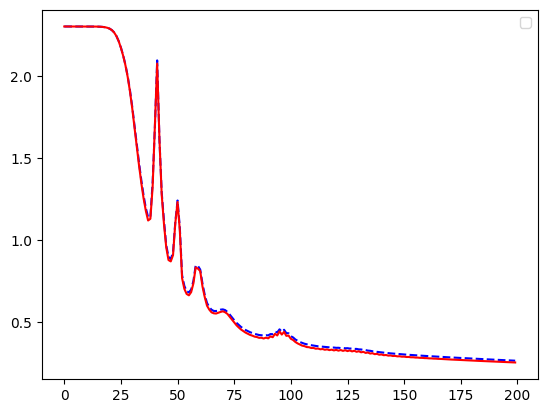

In [15]:
params = init_params([feature_train.shape[1], 128, 10])
num_iters = 200
learning_rate = 1e-5
losses_train, losses_test = [], []
# Optimization loop
for i in range(num_iters):
    pred_train, cache = forward(feature_train, params)
    pred_test, _ = forward(feature_test, params)
    grads = grad(pred_train, target_train, params, cache)
    loss_train = cross_entropy_loss_fn(pred_train, target_train)
    loss_test = cross_entropy_loss_fn(pred_test, target_test)
    for j in range(len(params)):
        params['layer' + str(j + 1)]['W'] = params['layer' + str(j + 1)]['W'] - learning_rate * grads['dW' + str(j + 1)]
        params['layer' + str(j + 1)]['b'] = params['layer' + str(j + 1)]['b'] - learning_rate * grads['db' + str(j + 1)]
    print(f"Iteration {i+1} training loss: {loss_train}, test loss: {loss_test}")
    losses_train.append(loss_train)
    losses_test.append(loss_test)

plt.plot(range(num_iters), losses_train, 'b--', range(num_iters), losses_test, 'r')
plt.legend()

## Prediction Accuracy on Test Data

In [16]:
pred_test, _ = forward(feature_test, params)  # make predictions on test features
pred_class_test = pred_test.argmax(axis=1)
pred_correctness = pred_class_test==test_target_array
num_correct = pred_correctness.sum()
accuracy = num_correct / test_target_array.size
print(accuracy)
# prediction_correctness = category_test==target_test  # Find out which predictions are correct
# num_correct = prediction_correctness.sum()  # Calculate how many correct predictions are made
# accuracy = num_correct / target_test.shape[0]  # Calculate accuracy rate: correct # / total #

0.9292
